In [1]:
import sys; sys.path.append('..')
import re

from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.config_store import ConfigStore

from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers.training_args import TrainingArguments
import torch
import torch.nn.functional as F
from transformers import RobertaPreLayerNormForMaskedLM, AutoConfig


from collections import defaultdict

from src.trainer import CustomTrainer
from src.utils.data import DatasetPreprocessor 

from src.config import BabyLMConfig
from src.models import load_base_model
from src.tokenizer import load_tokenizer

from tqdm import tqdm

/home/rd654/.cache/pypoetry/virtualenvs/pos-merge-Cf-JYAyy-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data utils and helper functions

In [2]:
def base_collate_fn(_samples):
    joined_batch = defaultdict(list)
    for sample in _samples:
        for key, val in sample.items():
            joined_batch[key].append(torch.tensor(val))

    batch = {}

    for key, val in joined_batch.items():
        batch[key] = torch.stack(val)

    return batch

In [3]:
class AnisotropyComputation: 
    def __init__(
        self,
        num_layers=8,
        layer_name_template=re.compile("roberta_prelayernorm.encoder.layer.(\d+).output$")
    ):
        self.num_layers = num_layers
        self.layer_name_template = layer_name_template

        self.cosine_sims = defaultdict(list)
    
    def get_fw_hook(self, module_name):
        def _forward_hook(module, _, module_out):
            # compute the cosine similarity between two random vectors in module_output
            # between first and second element of batch
            indices = torch.randint(0, 128, (2,))
            selected_vectors = torch.stack([module_out[i, index] for i, index in enumerate(indices)])
            cosine_sim = F.cosine_similarity(selected_vectors[0].unsqueeze(0), selected_vectors[1].unsqueeze(0))

            self.cosine_sims[module_name].append(cosine_sim.item())
       
        return _forward_hook

    def setup_hooks(self, model):
        for name, module in model.named_modules():
            if self.layer_name_template.match(name):
                module.register_forward_hook(self.get_fw_hook(name))


In [ ]:
cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)


baseline_model_path = "/home/rd654/pos-merge/models/pos_merge-roberta_pre_layer_norm-model/lm_model"

with initialize(version_base=None, config_path="../conf",):
    cfg = compose(
        config_name="config",
        overrides=[
            "experiment.name=baseline_clean",
            "experiment.group=anisotropy",
            "dataset=strict_small_gold",
            "experiment.offline_run=True",
        ])
        


In [ ]:
dataset = load_dataset(
    cfg.dataset.name,
    cfg.dataset.subconfig,
)  # type: ignore
tokenizer = load_tokenizer(cfg)
data_preprocessor = DatasetPreprocessor(cfg, tokenizer)
eval_dataset = dataset["validation"].map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset["validation"].column_names,
    load_from_cache_file=False,
)

### Baseline Model Anisotropy Computation

In [6]:
baseline_model_config = AutoConfig.from_pretrained(baseline_model_path)
baseline_model = RobertaPreLayerNormForMaskedLM.from_pretrained(baseline_model_path)
baseline_model.cuda()
baseline_model.eval()

RobertaPreLayerNormForMaskedLM(
  (roberta_prelayernorm): RobertaPreLayerNormModel(
    (embeddings): RobertaPreLayerNormEmbeddings(
      (word_embeddings): Embedding(8192, 256, padding_idx=1)
      (position_embeddings): Embedding(512, 256, padding_idx=1)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaPreLayerNormEncoder(
      (layer): ModuleList(
        (0): RobertaPreLayerNormLayer(
          (attention): RobertaPreLayerNormAttention(
            (self): RobertaPreLayerNormSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaPreLayerNormSelfOutput(
   

In [13]:
# random shuffle eval_dataset
eval_dataset = eval_dataset.shuffle(seed=42)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size = 2,
    collate_fn=base_collate_fn,
)

In [8]:
baseline_anisotropy_computation = AnisotropyComputation()
baseline_anisotropy_computation.setup_hooks(baseline_model)

In [9]:
for batch_idx, _batch in tqdm(enumerate(eval_dataloader)):
    if batch_idx > 1000:
        break

    batch  = {
        "input_ids": _batch["input_ids"].to("cuda"),
        "attention_mask": _batch["attention_mask"].to("cuda"),
    }
    baseline_model_output = baseline_model(**batch)

100%|██████████| 53277/53277 [13:54<00:00, 63.82it/s]


In [67]:
print("BASELINE RESULTS")
for layer_name in baseline_anisotropy_computation.cosine_sims.keys():
    # average the cosine similarities
    baseline_cosine_sims = baseline_anisotropy_computation.cosine_sims[layer_name]
    baseline_avg_cosine_sim = sum(baseline_cosine_sims) / len(baseline_cosine_sims)

    print(f"Layer: {layer_name}")
    print(f"Label smoothing avg cosine sim: {baseline_avg_cosine_sim}")

BASELINE RESULTS
Layer: roberta_prelayernorm.encoder.layer.0.output
Label smoothing avg cosine sim: 0.3433568946595581
Layer: roberta_prelayernorm.encoder.layer.1.output
Label smoothing avg cosine sim: 0.5185323326796372
Layer: roberta_prelayernorm.encoder.layer.2.output
Label smoothing avg cosine sim: 0.5281436800235679
Layer: roberta_prelayernorm.encoder.layer.3.output
Label smoothing avg cosine sim: 0.5132462359630755
Layer: roberta_prelayernorm.encoder.layer.4.output
Label smoothing avg cosine sim: 0.519649225508813
Layer: roberta_prelayernorm.encoder.layer.5.output
Label smoothing avg cosine sim: 0.5047696811129256
Layer: roberta_prelayernorm.encoder.layer.6.output
Label smoothing avg cosine sim: 0.5201953046251375
Layer: roberta_prelayernorm.encoder.layer.7.output
Label smoothing avg cosine sim: 0.4949028764975487


### POS Smoothing Model Anisotropy Computation

In [57]:
pos_smoothing_model_path = "/home/rd654/pos-merge/models/tied_cosine_lin_08_08/lm_model"

In [58]:
pos_smoothing_model_config = AutoConfig.from_pretrained(pos_smoothing_model_path)
pos_smoothing_model = RobertaPreLayerNormForMaskedLM.from_pretrained(pos_smoothing_model_path)
pos_smoothing_model.cuda()
pos_smoothing_model.eval()


RobertaPreLayerNormForMaskedLM(
  (roberta_prelayernorm): RobertaPreLayerNormModel(
    (embeddings): RobertaPreLayerNormEmbeddings(
      (word_embeddings): Embedding(8192, 256, padding_idx=1)
      (position_embeddings): Embedding(512, 256, padding_idx=1)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaPreLayerNormEncoder(
      (layer): ModuleList(
        (0): RobertaPreLayerNormLayer(
          (attention): RobertaPreLayerNormAttention(
            (self): RobertaPreLayerNormSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaPreLayerNormSelfOutput(
   

In [59]:
eval_dataset = eval_dataset.shuffle(seed=42)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size = 2,
    collate_fn=base_collate_fn,
)

In [60]:
pos_smoothing_anisotropy_computation = AnisotropyComputation()
pos_smoothing_anisotropy_computation.setup_hooks(pos_smoothing_model)

In [61]:
for idx, _batch in tqdm(enumerate(eval_dataloader)):

    if idx > 1_000:
        break 

    batch  = {
        "input_ids": _batch["input_ids"].to("cuda"),
        "attention_mask": _batch["attention_mask"].to("cuda"),
    }
    pos_smoothing_model_output = pos_smoothing_model(**batch)

1001it [00:18, 55.24it/s]


In [62]:
print("POS SMOOTHING RESULTS")
for layer_name in pos_smoothing_anisotropy_computation.cosine_sims.keys():
    # average the cosine similarities
    pos_smoothing_cosine_sims = pos_smoothing_anisotropy_computation.cosine_sims[layer_name]
    pos_smoothing_avg_cosine_sim = sum(pos_smoothing_cosine_sims) / len(pos_smoothing_cosine_sims)

    print(f"Layer: {layer_name}")
    print(f"Label smoothing avg cosine sim: {pos_smoothing_avg_cosine_sim}")

POS SMOOTHING RESULTS
Layer: roberta_prelayernorm.encoder.layer.0.output
Label smoothing avg cosine sim: 0.2706220190060945
Layer: roberta_prelayernorm.encoder.layer.1.output
Label smoothing avg cosine sim: 0.3794020617363991
Layer: roberta_prelayernorm.encoder.layer.2.output
Label smoothing avg cosine sim: 0.3808936393567613
Layer: roberta_prelayernorm.encoder.layer.3.output
Label smoothing avg cosine sim: 0.3289081412990886
Layer: roberta_prelayernorm.encoder.layer.4.output
Label smoothing avg cosine sim: 0.3371795227231977
Layer: roberta_prelayernorm.encoder.layer.5.output
Label smoothing avg cosine sim: 0.37615031983468916
Layer: roberta_prelayernorm.encoder.layer.6.output
Label smoothing avg cosine sim: 0.3598732343994892
Layer: roberta_prelayernorm.encoder.layer.7.output
Label smoothing avg cosine sim: 0.28189891604690365


### Label Smoothing Model Anisotropy Computation

In [38]:
label_smoothing_model_path = "/home/rd654/pos-merge/models/tied_baseline_label_smoothing/lm_model"

In [39]:
label_smoothing_model_config = AutoConfig.from_pretrained(label_smoothing_model_path)
label_smoothing_model = RobertaPreLayerNormForMaskedLM.from_pretrained(label_smoothing_model_path)
label_smoothing_model.cuda()
label_smoothing_model.eval()


RobertaPreLayerNormForMaskedLM(
  (roberta_prelayernorm): RobertaPreLayerNormModel(
    (embeddings): RobertaPreLayerNormEmbeddings(
      (word_embeddings): Embedding(8192, 256, padding_idx=1)
      (position_embeddings): Embedding(512, 256, padding_idx=1)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaPreLayerNormEncoder(
      (layer): ModuleList(
        (0): RobertaPreLayerNormLayer(
          (attention): RobertaPreLayerNormAttention(
            (self): RobertaPreLayerNormSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaPreLayerNormSelfOutput(
   

In [42]:
# random shuffle eval_dataset
eval_dataset = eval_dataset.shuffle(seed=42)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size = 2,
    collate_fn=base_collate_fn,
)

In [43]:
label_smoothing_anisotropy_computation = AnisotropyComputation()
label_smoothing_anisotropy_computation.setup_hooks(label_smoothing_model)

In [44]:
for idx, _batch in tqdm(enumerate(eval_dataloader)):

    if idx > 1_000:
        break 

    batch  = {
        "input_ids": _batch["input_ids"].to("cuda"),
        "attention_mask": _batch["attention_mask"].to("cuda"),
    }
    label_smoothing_model_output = label_smoothing_model(**batch)

1001it [00:17, 58.34it/s]


In [49]:
print("LABEL SMOOTHING RESULTS")
for layer_name in label_smoothing_anisotropy_computation.cosine_sims.keys():
    # average the cosine similarities
    label_smoothing_cosine_sims = label_smoothing_anisotropy_computation.cosine_sims[layer_name]
    label_smoothing_avg_cosine_sim = sum(label_smoothing_cosine_sims) / len(label_smoothing_cosine_sims)

    print(f"Layer: {layer_name}")
    print(f"Label smoothing avg cosine sim: {label_smoothing_avg_cosine_sim}")

LABEL SMOOTHING RESULTS
Layer: roberta_prelayernorm.encoder.layer.0.output
Label smoothing avg cosine sim: 0.3341185946843692
Layer: roberta_prelayernorm.encoder.layer.1.output
Label smoothing avg cosine sim: 0.4312800140037284
Layer: roberta_prelayernorm.encoder.layer.2.output
Label smoothing avg cosine sim: 0.450046625044141
Layer: roberta_prelayernorm.encoder.layer.3.output
Label smoothing avg cosine sim: 0.4397071760880959
Layer: roberta_prelayernorm.encoder.layer.4.output
Label smoothing avg cosine sim: 0.4455120164257187
Layer: roberta_prelayernorm.encoder.layer.5.output
Label smoothing avg cosine sim: 0.4030209180120226
Layer: roberta_prelayernorm.encoder.layer.6.output
Label smoothing avg cosine sim: 0.3860304162918509
Layer: roberta_prelayernorm.encoder.layer.7.output
Label smoothing avg cosine sim: 0.3335717300792317


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.16642827, -0.06642827,  0.03357173,  0.13357173,  0.23357173,
         0.33357173,  0.43357173,  0.53357173,  0.63357173,  0.73357173,
         0.83357173]),
 <BarContainer object of 10 artists>)

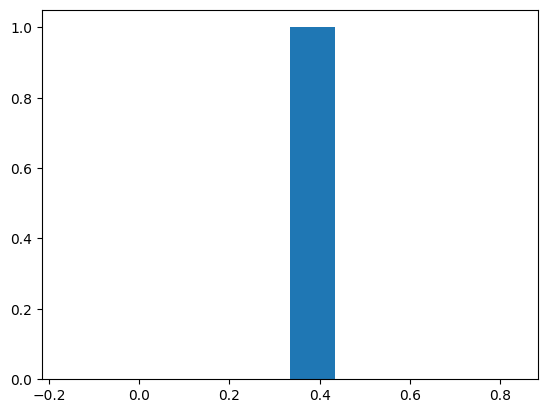

In [66]:
# plot out the cosine_sim on a plot 

import matplotlib.pyplot as plt

plt.hist(label_smoothing_avg_cosine_sim)

#### Analyzing Cosine Similarities

In [30]:
# save out cosine sims
import pickle

with open("baseline_cosine_sims.pkl", "wb") as f:
    pickle.dump(baseline_anisotropy_computation.cosine_sims, f)

with open("pos_smoothing_cosine_sims.pkl", "wb") as f:
    pickle.dump(pos_smoothing_anisotropy_computation.cosine_sims, f)

In [28]:
# remove the first 254 elements from the pos_smoothing_avg_cosine_sim 

pos_smoothing_avg_cosine_sim = {k: v[-53277:] for k, v in pos_smoothing_anisotropy_computation.cosine_sims.items()}
pos_smoothing_anisotropy_computation.cosine_sims = pos_smoothing_avg_cosine_sim

In [31]:
for layer_name in pos_smoothing_anisotropy_computation.cosine_sims.keys():
    # average the cosine similarities
    baseline_cosine_sims = baseline_anisotropy_computation.cosine_sims[layer_name]
    pos_smoothing_cosine_sims = pos_smoothing_anisotropy_computation.cosine_sims[layer_name]

    print(len(baseline_cosine_sims))
    print(len(pos_smoothing_cosine_sims))

    baseline_avg_cosine_sim = sum(baseline_cosine_sims) / len(baseline_cosine_sims)
    pos_smoothing_avg_cosine_sim = sum(pos_smoothing_cosine_sims) / len(pos_smoothing_cosine_sims)

    print(f"Layer: {layer_name}")
    print(f"Baseline avg cosine sim: {baseline_avg_cosine_sim}")
    print(f"Pos smoothing avg cosine sim: {pos_smoothing_avg_cosine_sim}")

53277
53277
Layer: roberta_prelayernorm.encoder.layer.0.output
Baseline avg cosine sim: 0.3433568946595581
Pos smoothing avg cosine sim: 0.39338837753643396
53277
53277
Layer: roberta_prelayernorm.encoder.layer.1.output
Baseline avg cosine sim: 0.5185323326796372
Pos smoothing avg cosine sim: 0.4872826279238394
53277
53277
Layer: roberta_prelayernorm.encoder.layer.2.output
Baseline avg cosine sim: 0.5281436800235679
Pos smoothing avg cosine sim: 0.5059412399081986
53277
53277
Layer: roberta_prelayernorm.encoder.layer.3.output
Baseline avg cosine sim: 0.5132462359630755
Pos smoothing avg cosine sim: 0.512955156903789
53277
53277
Layer: roberta_prelayernorm.encoder.layer.4.output
Baseline avg cosine sim: 0.519649225508813
Pos smoothing avg cosine sim: 0.5076678278069083
53277
53277
Layer: roberta_prelayernorm.encoder.layer.5.output
Baseline avg cosine sim: 0.5047696811129256
Pos smoothing avg cosine sim: 0.5285960882678392
53277
53277
Layer: roberta_prelayernorm.encoder.layer.6.output
Ba

In [19]:
k# save out cosine sims
import pickle

with open("baseline_cosine_sims.pkl", "wb") as f:
    pickle.dump(baseline_anisotropy_computation.cosine_sims, f)

with open("pos_smoothing_cosine_sims.pkl", "wb") as f:
    pickle.dump(pos_smoothing_anisotropy_computation.cosine_sims, f)